# 18.3 Causal vs Predictive Models

**Chapter**: 18 - Heterogeneous Treatment Effects  
**Section**: 3 - Causal vs Predictive Models  
**Facure Source**: 18-Heterogeneous-Treatment-Effects-and-Personalization.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-16

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Different Goals](#11-different-goals)
   - 1.2 [Why Prediction Isn't Enough](#12-why-prediction-isnt-enough)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Predictive vs Causal Targets](#21-predictive-vs-causal-targets)
   - 2.2 [Slope vs Level](#22-slope-vs-level)
3. [Implementation](#3-implementation)
   - 3.1 [CATE Model](#31-cate-model)
   - 3.2 [Predictive Model](#32-predictive-model)
   - 3.3 [Segmentation Comparison](#33-segmentation-comparison)
4. [Numeric Demonstration](#4-numeric-demonstration)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

set_notebook_style()
np.random.seed(123)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding the difference between prediction and causal inference is fundamental. Many DS roles require explaining why good prediction doesn't solve the causal problem.

### 1.1 Different Goals

**Predictive model**: Estimates $E[Y|X, T]$
- "What will Y be given these inputs?"
- Passive observation

**Causal (CATE) model**: Estimates $\frac{\partial E[Y|X, T]}{\partial T}$
- "How will Y change if I change T?"
- Active intervention

```
Predictive vs Causal Targets ────────────────────────────

  Predictive:  E[Y | X, T]
               "What sales to expect on this day?"
               
  Causal:      ∂E[Y | X, T] / ∂T
               "How will sales change if I change price?"
               
  A model can be excellent at prediction
  but USELESS for treatment decisions!
─────────────────────────────────────────────────────────
```

### 1.2 Why Prediction Isn't Enough

Imagine you're an ice cream seller. A predictive model tells you:
- "Tomorrow you'll sell 200 units"

But you want to know:
- "If I raise the price by $1, how many fewer sales will I have?"

The predictive model might segment customers into:
- High sales days vs Low sales days

But you need to segment by:
- Price-sensitive days vs Price-insensitive days

**These are not the same!**

In [2]:
# Load and prepare data
prices_rnd = load_facure_data('ice_cream_sales_rnd.csv')
train, test = train_test_split(prices_rnd, test_size=0.25, random_state=123)

X = ["temp", "weekday", "cost", "price"]
y = "sales"

print("=" * 60)
print("DATA SETUP")
print("=" * 60)
print(f"\nTraining set: {len(train):,} observations")
print(f"Test set: {len(test):,} observations")
print(f"\nFeatures: {X}")
print(f"Outcome: {y}")

DATA SETUP

Training set: 3,750 observations
Test set: 1,250 observations

Features: ['temp', 'weekday', 'cost', 'price']
Outcome: sales


---

## 2. Formal Treatment

### 2.1 Predictive vs Causal Targets

| Aspect | Predictive Model | Causal Model |
|--------|-----------------|---------------|
| Target | $E[Y|X, T]$ | $\frac{\partial E[Y|X,T]}{\partial T}$ |
| Question | What will Y be? | How does Y change with T? |
| Segments by | Outcome level | Treatment effect |
| Use case | Forecasting | Treatment decisions |

### 2.2 Slope vs Level

Consider the relationship between price and sales:

- **Level** (predictive): How many sales on this day?
- **Slope** (causal): What's the price-sales relationship on this day?

A day can have:
- High sales AND high price sensitivity (hot, busy weekend)
- High sales AND low price sensitivity (special event)
- Low sales AND high price sensitivity (cold, quiet day)
- Low sales AND low price sensitivity (rain, everyone stayed home)

**Predictive models segment by level. Causal models segment by slope.**

---

## 3. Implementation

### 3.1 CATE Model

In [3]:
# CATE model: regression with interactions
cate_model = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

# Predict sensitivity
def predict_sensitivity(model, df, t_col="price", h=1):
    df_plus = df.copy()
    df_plus[t_col] = df[t_col] + h
    return (model.predict(df_plus) - model.predict(df)) / h

test = test.copy()
test['sensitivity_pred'] = predict_sensitivity(cate_model, test)

print("CATE Model (Sensitivity Predictions):")
print(f"  Mean: {test['sensitivity_pred'].mean():.3f}")
print(f"  Std:  {test['sensitivity_pred'].std():.3f}")
print(f"  Min:  {test['sensitivity_pred'].min():.3f}")
print(f"  Max:  {test['sensitivity_pred'].max():.3f}")

CATE Model (Sensitivity Predictions):
  Mean: -2.509
  Std:  4.522
  Min:  -10.597
  Max:  1.389


### 3.2 Predictive Model

In [4]:
# Predictive model: ML model to predict sales
ml_model = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=42)
ml_model.fit(train[X], train[y])

# Check model quality
train_r2 = ml_model.score(train[X], train[y])
test_r2 = ml_model.score(test[X], test[y])

print(f"Predictive Model (Sales Predictions):")
print(f"  Train R²: {train_r2:.3f}")
print(f"  Test R²:  {test_r2:.3f}")

# Add predictions to test set
test['sales_pred'] = ml_model.predict(test[X])

print(f"\n  Mean predicted: {test['sales_pred'].mean():.1f}")
print(f"  Mean actual:    {test['sales'].mean():.1f}")

Predictive Model (Sales Predictions):
  Train R²: 0.954
  Test R²:  0.937

  Mean predicted: 201.9
  Mean actual:    201.7


### 3.3 Segmentation Comparison

In [5]:
# Create bands from each model
test['sens_band'] = pd.qcut(test['sensitivity_pred'], q=2, labels=['High Sens', 'Low Sens'])
test['pred_band'] = pd.qcut(test['sales_pred'], q=2, labels=['Low Sales', 'High Sales'])

# Add a random model for comparison
np.random.seed(42)
test['random_pred'] = np.random.uniform(size=len(test))
test['rand_band'] = pd.qcut(test['random_pred'], q=2, labels=['Random A', 'Random B'])

print("=" * 60)
print("SEGMENTATION COMPARISON")
print("=" * 60)

# Cross-tabulation
print("\nCross-tabulation: CATE bands vs Predictive bands")
print(pd.crosstab(test['sens_band'], test['pred_band'], margins=True))

SEGMENTATION COMPARISON

Cross-tabulation: CATE bands vs Predictive bands
pred_band  Low Sales  High Sales   All
sens_band                             
High Sens        353         272   625
Low Sens         272         353   625
All              625         625  1250


In [6]:
# Compute actual sensitivity within each band
def compute_actual_sensitivity(df, y_col='sales', t_col='price'):
    """
    Compute sensitivity as the slope coefficient from regressing Y on T.
    """
    cov = np.sum((df[t_col] - df[t_col].mean()) * (df[y_col] - df[y_col].mean()))
    var = np.sum((df[t_col] - df[t_col].mean())**2)
    return cov / var if var > 0 else 0

# Sensitivity by CATE bands
print("\n" + "=" * 60)
print("ACTUAL SENSITIVITY BY BAND")
print("=" * 60)

print("\nCATE Model Bands:")
for band in ['High Sens', 'Low Sens']:
    subset = test[test['sens_band'] == band]
    actual_sens = compute_actual_sensitivity(subset)
    print(f"  {band}: actual sensitivity = {actual_sens:.2f} (n={len(subset)})")

print("\nPredictive Model Bands:")
for band in ['Low Sales', 'High Sales']:
    subset = test[test['pred_band'] == band]
    actual_sens = compute_actual_sensitivity(subset)
    print(f"  {band}: actual sensitivity = {actual_sens:.2f} (n={len(subset)})")

print("\nRandom Model Bands:")
for band in ['Random A', 'Random B']:
    subset = test[test['rand_band'] == band]
    actual_sens = compute_actual_sensitivity(subset)
    print(f"  {band}: actual sensitivity = {actual_sens:.2f} (n={len(subset)})")


ACTUAL SENSITIVITY BY BAND

CATE Model Bands:
  High Sens: actual sensitivity = -5.73 (n=625)
  Low Sens: actual sensitivity = 0.88 (n=625)

Predictive Model Bands:
  Low Sales: actual sensitivity = -0.61 (n=625)
  High Sales: actual sensitivity = -1.79 (n=625)

Random Model Bands:
  Random A: actual sensitivity = -2.23 (n=625)
  Random B: actual sensitivity = -2.44 (n=625)


---

## 4. Numeric Demonstration

Let's visualize the key difference: **CATE separates by slope, Prediction separates by level**.

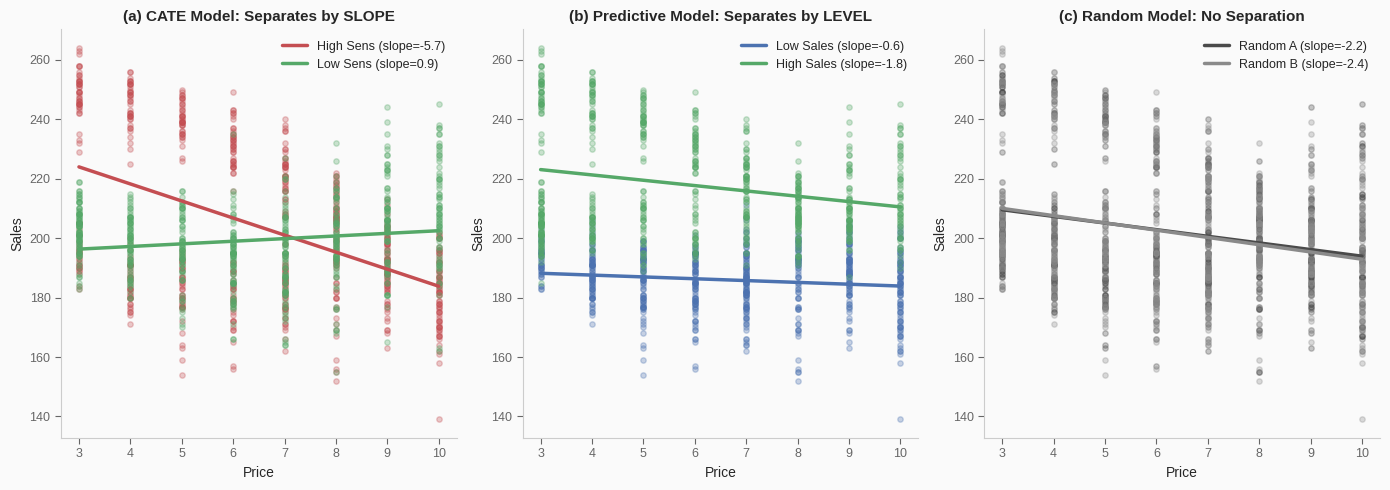

In [7]:
# Visualize the segmentations using FacetGrid-style plots
fig, axes = create_tufte_figure(1, 3, figsize=(14, 5))

# Helper function to plot with regression line
def plot_band_slopes(ax, df, band_col, title, colors_dict):
    for band in df[band_col].unique():
        subset = df[df[band_col] == band]
        color = colors_dict.get(band, TUFTE_PALETTE['primary'])
        
        # Scatter
        ax.scatter(subset['price'], subset['sales'], alpha=0.3, s=15, c=color)
        
        # Regression line
        z = np.polyfit(subset['price'], subset['sales'], 1)
        x_range = np.linspace(subset['price'].min(), subset['price'].max(), 100)
        ax.plot(x_range, np.poly1d(z)(x_range), c=color, lw=2.5, label=f'{band} (slope={z[0]:.1f})')
    
    ax.set_xlabel('Price')
    ax.set_ylabel('Sales')
    ax.set_title(title, fontweight='bold')
    ax.legend(frameon=False, fontsize=9)

# Panel 1: CATE model segmentation
cate_colors = {'High Sens': COLORS['red'], 'Low Sens': COLORS['green']}
plot_band_slopes(axes[0], test, 'sens_band', '(a) CATE Model: Separates by SLOPE', cate_colors)

# Panel 2: Predictive model segmentation
pred_colors = {'Low Sales': COLORS['blue'], 'High Sales': COLORS['green']}
plot_band_slopes(axes[1], test, 'pred_band', '(b) Predictive Model: Separates by LEVEL', pred_colors)

# Panel 3: Random model segmentation
rand_colors = {'Random A': TUFTE_PALETTE['primary'], 'Random B': TUFTE_PALETTE['secondary']}
plot_band_slopes(axes[2], test, 'rand_band', '(c) Random Model: No Separation', rand_colors)

plt.tight_layout()
plt.show()

In [8]:
# Key insight visualization
print("=" * 60)
print("KEY INSIGHT")
print("=" * 60)
print("""
Look at the SLOPES of the regression lines:

(a) CATE Model:
    - High Sens: STEEPER negative slope (more price sensitive)
    - Low Sens: FLATTER slope (less price sensitive)
    -> Successfully separates by treatment response!

(b) Predictive Model:
    - Both bands have SIMILAR slopes
    - Only separated on Y-axis (sales level)
    -> Does NOT separate by treatment response!
    
(c) Random Model:
    - Both bands have SAME slope (as expected)
    -> Useless for treatment decisions
""")

KEY INSIGHT

Look at the SLOPES of the regression lines:

(a) CATE Model:
    - High Sens: STEEPER negative slope (more price sensitive)
    - Low Sens: FLATTER slope (less price sensitive)
    -> Successfully separates by treatment response!

(b) Predictive Model:
    - Both bands have SIMILAR slopes
    - Only separated on Y-axis (sales level)
    -> Does NOT separate by treatment response!

(c) Random Model:
    - Both bands have SAME slope (as expected)
    -> Useless for treatment decisions



In [9]:
# Quantify the difference in slopes
print("=" * 60)
print("SLOPE COMPARISON")
print("=" * 60)

def get_slope(df):
    return np.polyfit(df['price'], df['sales'], 1)[0]

# CATE model
cate_high = get_slope(test[test['sens_band'] == 'High Sens'])
cate_low = get_slope(test[test['sens_band'] == 'Low Sens'])
print(f"\nCATE Model:")
print(f"  High Sensitivity band slope: {cate_high:.2f}")
print(f"  Low Sensitivity band slope:  {cate_low:.2f}")
print(f"  Difference: {abs(cate_high - cate_low):.2f}")

# Predictive model
pred_low = get_slope(test[test['pred_band'] == 'Low Sales'])
pred_high = get_slope(test[test['pred_band'] == 'High Sales'])
print(f"\nPredictive Model:")
print(f"  Low Sales band slope:  {pred_low:.2f}")
print(f"  High Sales band slope: {pred_high:.2f}")
print(f"  Difference: {abs(pred_low - pred_high):.2f}")

# Random model
rand_a = get_slope(test[test['rand_band'] == 'Random A'])
rand_b = get_slope(test[test['rand_band'] == 'Random B'])
print(f"\nRandom Model:")
print(f"  Random A band slope: {rand_a:.2f}")
print(f"  Random B band slope: {rand_b:.2f}")
print(f"  Difference: {abs(rand_a - rand_b):.2f}")

print(f"\n-> CATE model creates bands with DIFFERENT slopes!")
print(f"-> Predictive model creates bands with SIMILAR slopes.")

SLOPE COMPARISON

CATE Model:
  High Sensitivity band slope: -5.73
  Low Sensitivity band slope:  0.88
  Difference: 6.62

Predictive Model:
  Low Sales band slope:  -0.61
  High Sales band slope: -1.79
  Difference: 1.18

Random Model:
  Random A band slope: -2.23
  Random B band slope: -2.44
  Difference: 0.21

-> CATE model creates bands with DIFFERENT slopes!
-> Predictive model creates bands with SIMILAR slopes.


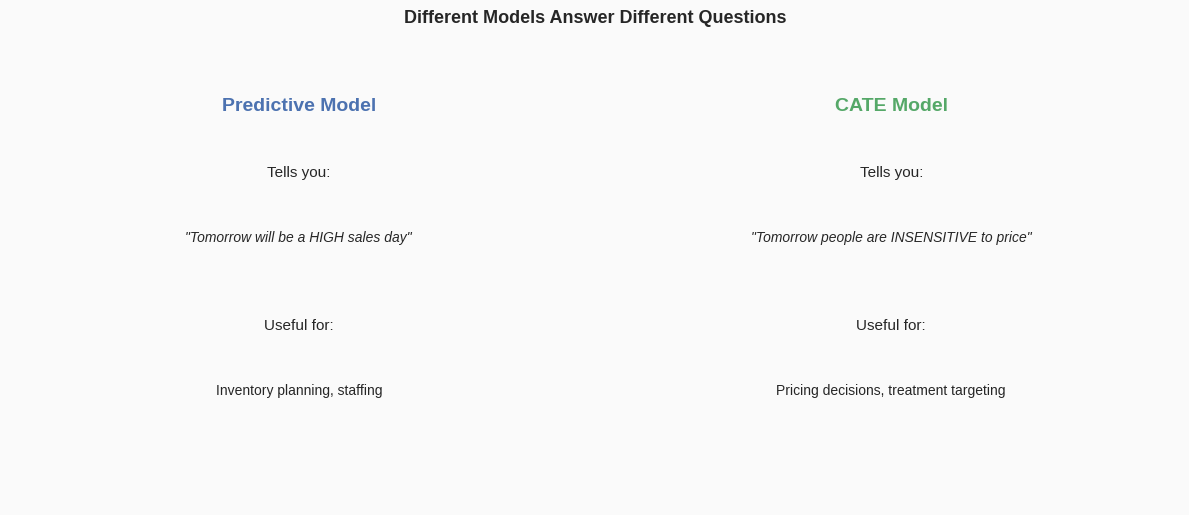

In [10]:
# Business implications
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: What each model tells you
ax = axes[0]
ax.text(0.5, 0.9, 'Predictive Model', fontsize=14, fontweight='bold', 
        ha='center', transform=ax.transAxes, color=COLORS['blue'])
ax.text(0.5, 0.75, 'Tells you:', fontsize=11, 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.6, '"Tomorrow will be a HIGH sales day"', fontsize=10, 
        ha='center', transform=ax.transAxes, style='italic')
ax.text(0.5, 0.4, 'Useful for:', fontsize=11, 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.25, 'Inventory planning, staffing', fontsize=10, 
        ha='center', transform=ax.transAxes)
ax.axis('off')

# Panel 2: What CATE model tells you
ax = axes[1]
ax.text(0.5, 0.9, 'CATE Model', fontsize=14, fontweight='bold', 
        ha='center', transform=ax.transAxes, color=COLORS['green'])
ax.text(0.5, 0.75, 'Tells you:', fontsize=11, 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.6, '"Tomorrow people are INSENSITIVE to price"', fontsize=10, 
        ha='center', transform=ax.transAxes, style='italic')
ax.text(0.5, 0.4, 'Useful for:', fontsize=11, 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.25, 'Pricing decisions, treatment targeting', fontsize=10, 
        ha='center', transform=ax.transAxes)
ax.axis('off')

plt.suptitle('Different Models Answer Different Questions', fontweight='bold', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

```
Key Takeaways ───────────────────────────────────────────

1. Prediction ≠ Causal inference
   - Predictive: E[Y|X,T] (what will happen)
   - Causal: ∂E[Y|X,T]/∂T (how will it change)

2. Different segmentation
   - Predictive segments by LEVEL (high/low outcome)
   - CATE segments by SLOPE (responsive/unresponsive)

3. For treatment decisions, you need CATE
   - Predictive model: "Tomorrow will have high sales"
   - CATE model: "Tomorrow I can raise prices"
   
4. A great predictive model can be USELESS for pricing
   - R² = 0.9 doesn't mean it helps with treatment
   - Need to evaluate on treatment effect separation
─────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Why can't we just use a good predictive model for treatment decisions?"*

<details>
<summary>Solution</summary>

**Key distinction: Different targets**

- Predictive model: $E[Y|X, T]$ → predicts outcome level
- Treatment decisions need: $\partial E[Y|X,T]/\partial T$ → predicts how outcome changes

**Why this matters**:

1. **Segmentation is different**:
   - Predictive segments by outcome level (high/low Y)
   - Treatment decisions need segmentation by responsiveness (high/low dY/dT)

2. **Correlation vs causation**:
   - Predictive model uses T as just another feature
   - Doesn't distinguish between T causing Y vs confounders affecting both

3. **Example**:
   - High-income customers might have high conversion AND low price sensitivity
   - Predictive model: "Target high-income customers" (high predicted conversion)
   - CATE model: "Don't discount to high-income" (they'll buy anyway)

**Bottom line**: Prediction answers "what will happen" but we need "what should I do."

</details>

---

**Q2 (Amazon L6, Econ)**: *"How do you evaluate whether a model is useful for treatment targeting?"*

<details>
<summary>Solution</summary>

**Key principle**: Evaluate on treatment effect separation, not prediction accuracy.

**Evaluation approaches**:

1. **Sensitivity by band**: 
   - Create quantile bands from model predictions
   - Compute actual treatment effect in each band
   - Good model → bands have different treatment effects

2. **Cumulative gain curve**:
   - Order units by predicted CATE
   - Plot cumulative treatment effect as you add more units
   - Good model → curve diverges from random baseline

3. **FacetGrid slopes**:
   - Create bands from predictions
   - Plot T vs Y relationship in each band
   - Good model → different slopes across bands

**Critical insight**: These require randomized data or valid causal identification.

**What NOT to do**:
- Evaluate on R² or RMSE (prediction metrics)
- These don't tell you about treatment effect heterogeneity

</details>

---

**Q3 (Google L5, Quant)**: *"Give an example where a predictive model would mislead treatment decisions."*

<details>
<summary>Solution</summary>

**Example: Email marketing campaign**

Setup:
- Treatment: Promotional email
- Outcome: Purchase
- Goal: Target customers who respond well to emails

**Predictive model approach**:
- Train model: P(purchase | customer features, email sent)
- Target customers with highest predicted P(purchase)

**Why this fails**:
- High-value customers have high P(purchase) regardless of email
- Model predicts high for these customers
- But their treatment effect might be ZERO (they'd buy anyway)
- Meanwhile, marginal customers might have lower P(purchase) but higher treatment effect

**Result**:
- Predictive targeting: Email to customers who would have purchased anyway
- CATE targeting: Email to customers who WOULDN'T have purchased without email

**Quantification**:
- Loyal customer: P(buy|email) = 0.9, P(buy|no email) = 0.88 → CATE = 0.02
- Marginal customer: P(buy|email) = 0.4, P(buy|no email) = 0.2 → CATE = 0.20

Predictive model targets loyal (0.9 > 0.4), but CATE model targets marginal (0.20 > 0.02).

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 18: "Heterogeneous Treatment Effects and Personalization."

[^2]: Athey, S. and Imbens, G. W. (2016). Recursive partitioning for heterogeneous causal effects. *PNAS*, 113(27), 7353-7360.

[^3]: Kunzel, S. R., Sekhon, J. S., Bickel, P. J., and Yu, B. (2019). Metalearners for estimating heterogeneous treatment effects using machine learning. *PNAS*, 116(10), 4156-4165.

[^4]: Breiman, L. (2001). Statistical Modeling: The Two Cultures. *Statistical Science*, 16(3), 199-231.

---

**Next Chapter**: [19. Evaluating Causal Models](../19_evaluating_causal/01_evaluation_challenge.ipynb) — How to know if your CATE model is working